<a href="https://colab.research.google.com/github/awaiskhan005/DATA-SCIENCE-AND-AI-/blob/main/TSLA_Forecasting_using_Pytorch_and_LSTM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid",
              palette="colorblind", color_codes=True,
              rc={"figure.figsize": [14, 5]})

In [4]:
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
plt.style.use('seaborn')
import torch
import torch.nn as nn
%matplotlib inline
plt.rcParams['figure.dpi']=110
plt.rcParams['savefig.dpi']=110

<ipython-input-4-d6a5657c0d09>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [5]:
ticker = ['TSLA']
start = datetime.datetime(2021,7, 30)
end = datetime.datetime(2023, 7, 30)
df = yf.download(ticker, start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [6]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-30,223.919998,232.509995,223.000000,229.066666,229.066666,88969200
2021-08-02,233.333328,242.313339,232.800003,236.556671,236.556671,100847400
2021-08-03,239.666672,240.883331,233.669998,236.580002,236.580002,64860900
2021-08-04,237.000000,241.633331,236.309998,236.973328,236.973328,51007800
2021-08-05,238.666672,240.316666,237.136673,238.210007,238.210007,38758800
...,...,...,...,...,...,...
2023-07-24,255.850006,269.850006,254.119995,269.059998,269.059998,136508500
2023-07-25,272.380005,272.899994,265.000000,265.279999,265.279999,112757300
2023-07-26,263.250000,268.040009,261.750000,264.350006,264.350006,95856200


In [8]:
!pip install pandas-bokeh

In [9]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import pandas_bokeh
cf.go_offline()
pandas_bokeh.output_notebook()

In [35]:
df['Close'].iplot()

In [11]:
fig_price=px.line(df['Close'], title='Price of TSLA')
fig_price.show()

In [12]:
df.reset_index(inplace=True)
df=df[['Date', 'Close']]

In [13]:
df

,Date,Close
0,2021-07-30,229.066666
1,2021-08-02,236.556671
2,2021-08-03,236.580002
3,2021-08-04,236.973328
4,2021-08-05,238.210007
...,...,...
497,2023-07-24,269.059998
498,2023-07-25,265.279999
499,2023-07-26,264.350006
500,2023-07-27,255.710007


In [14]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [15]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(df, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2021-08-10,236.663330,237.919998,233.033340,238.210007,236.973328,236.580002,236.556671,229.066666
2021-08-11,235.940002,236.663330,237.919998,233.033340,238.210007,236.973328,236.580002,236.556671
2021-08-12,240.750000,235.940002,236.663330,237.919998,233.033340,238.210007,236.973328,236.580002
2021-08-13,239.056671,240.750000,235.940002,236.663330,237.919998,233.033340,238.210007,236.973328
2021-08-16,228.723328,239.056671,240.750000,235.940002,236.663330,237.919998,233.033340,238.210007
...,...,...,...,...,...,...,...,...
2023-07-24,269.059998,260.019989,262.899994,291.260010,293.339996,290.380005,281.380005,277.899994
2023-07-25,265.279999,269.059998,260.019989,262.899994,291.260010,293.339996,290.380005,281.380005
2023-07-26,264.350006,265.279999,269.059998,260.019989,262.899994,291.260010,293.339996,290.380005


In [16]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[236.66333008, 237.91999817, 233.03334045, ..., 236.58000183,
        236.55667114, 229.06666565],
       [235.94000244, 236.66333008, 237.91999817, ..., 236.97332764,
        236.58000183, 236.55667114],
       [240.75      , 235.94000244, 236.66333008, ..., 238.21000671,
        236.97332764, 236.58000183],
       ...,
       [264.3500061 , 265.27999878, 269.05999756, ..., 291.26000977,
        293.33999634, 290.38000488],
       [255.71000671, 264.3500061 , 265.27999878, ..., 262.8999939 ,
        291.26000977, 293.33999634],
       [266.44000244, 255.71000671, 264.3500061 , ..., 260.01998901,
        262.8999939 , 291.26000977]])

In [17]:
shifted_df_as_np.shape

(495, 8)

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.14822056, -0.13989467, -0.17227057, ..., -0.14877264,
        -0.14892721, -0.19855126],
       [-0.15301287, -0.14822056, -0.13989467, ..., -0.14616671,
        -0.14877264, -0.14892721],
       [-0.12114486, -0.15301287, -0.14822056, ..., -0.13797325,
        -0.14616671, -0.14877264],
       ...,
       [ 0.03521387,  0.04137542,  0.0664193 , ...,  0.21350256,
         0.22728324,  0.20767221],
       [-0.0220293 ,  0.03521387,  0.04137542, ...,  0.02560701,
         0.21350256,  0.22728324],
       [ 0.04906087, -0.0220293 ,  0.03521387, ...,  0.00652592,
         0.02560701,  0.21350256]])

In [19]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((495, 7), (495,))

In [20]:
split_index = int(len(X) * 0.95)

split_index

470

In [21]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((470, 7), (25, 7), (470,), (25,))

In [22]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((470, 7, 1), (25, 7, 1), (470, 1), (25, 1))

In [23]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([470, 7, 1]),
 torch.Size([25, 7, 1]),
 torch.Size([470, 1]),
 torch.Size([25, 1]))

In [24]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [25]:
train_dataset

In [26]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [28]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [29]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [30]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [31]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.013
***************************************************

Epoch: 2

Val Loss: 0.012
***************************************************

Epoch: 3

Val Loss: 0.012
***************************************************

Epoch: 4

Val Loss: 0.011
***************************************************

Epoch: 5

Val Loss: 0.010
***************************************************

Epoch: 6

Val Loss: 0.010
***************************************************

Epoch: 7

Val Loss: 0.012
***************************************************

Epoch: 8

Val Loss: 0.014
***************************************************

Epoch: 9

Val Loss: 0.016
***************************************************

Epoch: 10

Val Loss: 0.015
***************************************************

Epoch: 11

Val Loss: 0.016
***************************************************

Epoch: 12

Val Loss: 0.015
***************************************************

Epoch: 13

Val Loss: 0.016
**********************

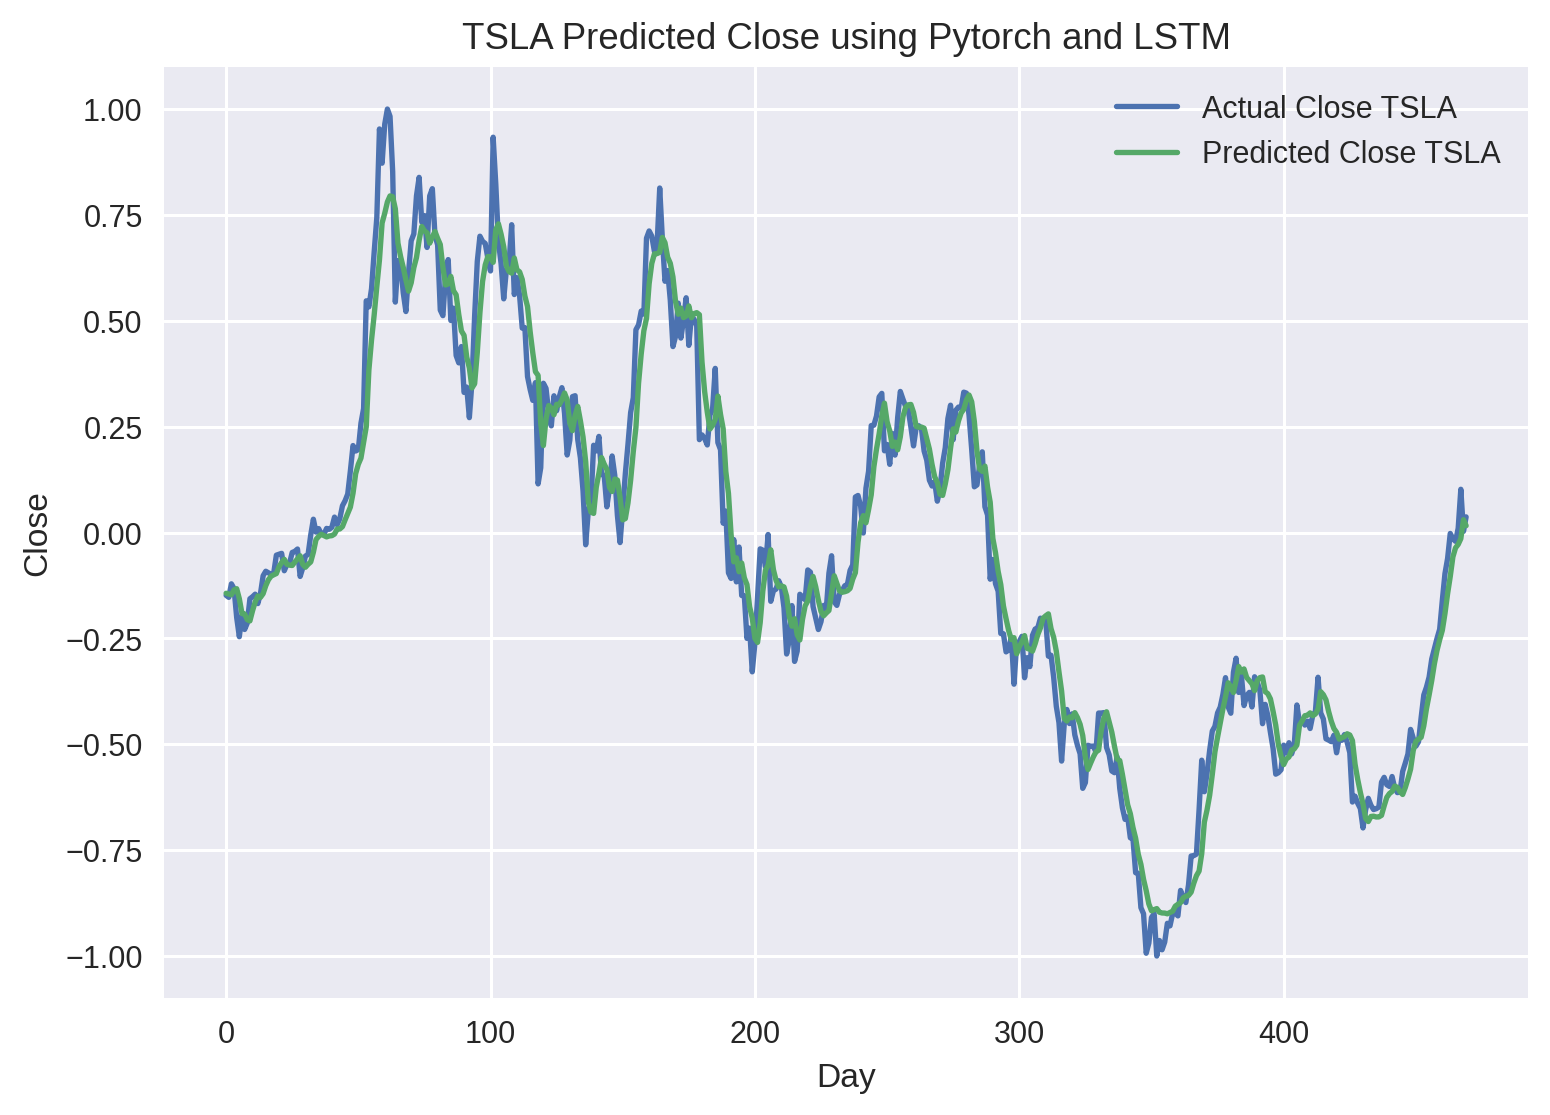

In [32]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close TSLA')
plt.plot(predicted, label='Predicted Close TSLA')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.title('TSLA Predicted Close using Pytorch and LSTM')
plt.show()

In [34]:
# prompt: make the same plot using plotly

fig_price_lstm=px.line(predicted, title='Price of TSLA using Pytorch and LSTM')
fig_price_lstm.show()
